# **Fitting a nonlinear surface to a pointcloud using Keras**

In [5]:
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt

## **Data generation**

![BMI](bmi.jpg)

Generate a surface with NxN points replicating the BMI table above. Height (H) varies from 1.4 to 2.1 meters and weight (W) varies from 40 to 130 kilograms. BMI values are computes as W/H^2. H, W and BMI are respectively mapped to x, y and z axes.

In [6]:
N = 20
min_height, max_height, min_weight, max_weight = 1.4, 2.1, 40, 130
min_bmi = int(min_weight/(max_height**2)+0.5)
max_bmi = int(max_weight/(min_height**2)+0.5)

# x and y coordinates
xtics = np.linspace(min_height, max_height, N)
ytics = np.linspace(min_weight, max_weight, N)

# 2D grid on x and y axes
x, y = np.meshgrid(xtics, ytics)

# use BMI as z coordinates
z = np.divide(y, np.square(x))

# input
X = np.concatenate((x.reshape((-1,1)), y.reshape((-1,1))), axis=1)
print(X.shape)

# output
Y = z.reshape((-1,1))
print(Y.shape)

# data normalization
x_ = (x-min_height)/(max_height-min_height)
y_ = (y-min_weight)/(max_weight-min_weight)
z_ = (z-min_bmi)/(max_bmi-min_bmi)

X_ = np.concatenate((x_.reshape((-1,1)), y_.reshape((-1,1))), axis=1)
Y_ = z_.reshape((-1,1))

(400, 2)
(400, 1)


## **Visualize surface**

Plot the surface created in the previous step. The colors of the plot follow the pattern of the BMI table.

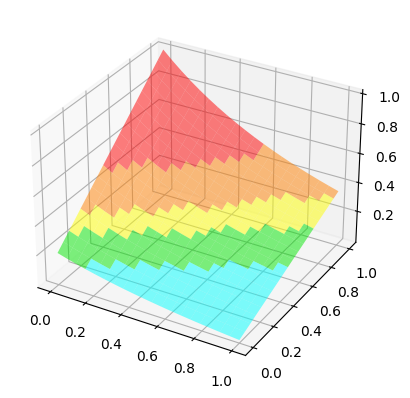

In [7]:
def show_surface(x, y, z, model=None):
  # 0-18: cyan / 19-24: green / 25-29: yellow / 30-39: orange / 40-*: red
  colors = [(0.0,1.0,1.0,0.5)]*(19-min_bmi) + [(0.0,0.9,0.0,0.5)]*6 + [(1.0,1.0,0.0,0.5)]*5 + [(1.0,0.5,0.0,0.5)]*10 + [(1.0,0.0,0.0,0.5)]*(max_bmi-39)
  cmap = matplotlib.colors.LinearSegmentedColormap.from_list('BMI', colors, N=len(colors))

  # plot surface
  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')
  ax.plot_surface(x, y, z, cmap=cmap)

  # plot line
  if model is not None:
    X_ = np.concatenate((x.reshape((-1,1)), y.reshape((-1,1))), axis=1)
    z_ = model.predict(X_).reshape(z.shape)
    ax.plot_wireframe(x, y, z_, color='black', lw=1)

  plt.show()

show_surface(x_, y_, z_)

## **Define network architecture**

Create an MLP with 8 hidden units.

In [8]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(8, activation='relu', input_shape=(2,)))
model.add(tf.keras.layers.Dense(1))

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 8)                 24        
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 33
Trainable params: 33
Non-trainable params: 0
_________________________________________________________________
None


In [15]:
input = tf.keras.Input(shape=(2,))
hidden = tf.keras.layers.Dense(8, activation='relu')(input)
output = tf.keras.layers.Dense(1)(hidden)
model = tf.keras.models.Model(inputs=input, outputs=output)

print(model.summary())

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_10 (Dense)            (None, 8)                 24        
                                                                 
 dense_11 (Dense)            (None, 1)                 9         
                                                                 
Total params: 33
Trainable params: 33
Non-trainable params: 0
_________________________________________________________________
None


## **Training**

Train a nonlinear function that maps xy-coordinates into z-coordinates using multiple gradient descent updates.

13/13 [==============================] - 0s 1ms/step


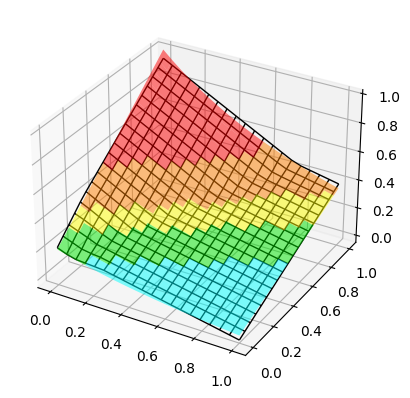

In [12]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1)
model.compile(loss='mean_squared_error', optimizer=optimizer)
model.fit(X_, Y_, batch_size=len(X_), epochs=2048, verbose=0)

show_surface(x_, y_, z_, model)

## **Stochastic Gradient Descent (SGD)**

Run gradient descent steps using random samples of the training data instead of using the entire set.

13/13 [==============================] - 0s 1ms/step


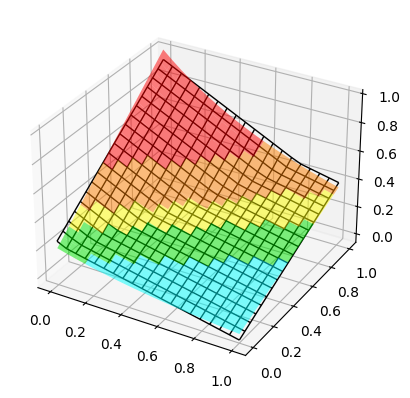

In [17]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1)
model.compile(loss='mean_squared_error', optimizer=optimizer)
model.fit(X_, Y_, batch_size=32, shuffle=True, epochs=64, verbose=0)

show_surface(x_, y_, z_, model)

---

# **Binary classification**

## **Adjust output**

BMI values below 25 are labeled as 'not overweight' (0) and above or equal to 25 as 'overweight' (1).

In [18]:
# output
Y = np.where(z.reshape((-1,1)) >= 25.0, 1.0, 0.0)

print(np.amin(Y), np.amax(Y))

0.0 1.0


## **Split data into training, validation and test**

To adequately evaluate the model, do not use the entire training set for training. Reserve a part of that as the validation set to tune hyperparameters. Never use test data for training or hyperparameter tuning. In real-life, you don't have access to the test data.

In [19]:
# random split: 25% for training, 25% for validation, 50% for testing
shuffle = np.random.permutation(len(X_))

X_train = X_.take(shuffle[:len(shuffle)//4], axis=0)
X_val = X_.take(shuffle[len(shuffle)//4:len(shuffle)//2], axis=0)
X_test = X_.take(shuffle[len(shuffle)//2:], axis=0)

Y_train = Y.take(shuffle[:len(shuffle)//4], axis=0)
Y_val = Y.take(shuffle[len(shuffle)//4:len(shuffle)//2], axis=0)
Y_test = Y.take(shuffle[len(shuffle)//2:], axis=0)

print(X_train.shape, X_val.shape, X_test.shape)
print(Y_train.shape, Y_val.shape, Y_test.shape)

(100, 2) (100, 2) (200, 2)
(100, 1) (100, 1) (200, 1)


## **Define network architecture**

Create an MLP with 8 hidden units.

In [20]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(8, activation='relu', input_shape=(2,)))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 8)                 24        
                                                                 
 dense_13 (Dense)            (None, 1)                 9         
                                                                 
Total params: 33
Trainable params: 33
Non-trainable params: 0
_________________________________________________________________
None


## **Training**

Train an MLP to check whether someone is overweight or not.

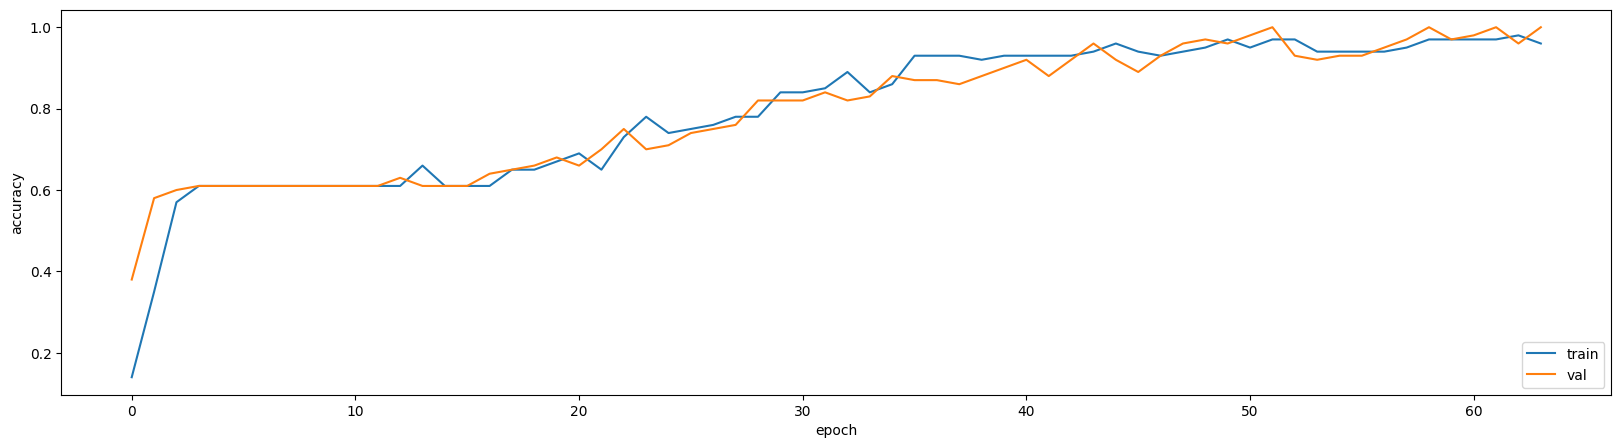

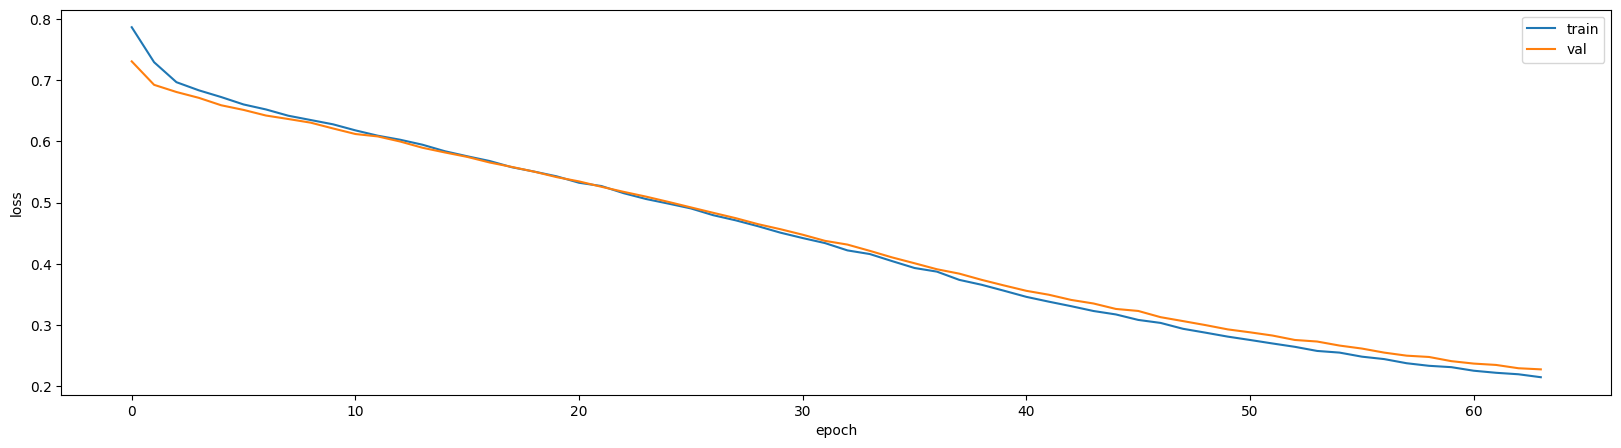

In [21]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

history = model.fit(X_train, Y_train, batch_size=32, validation_data=(X_val, Y_val), epochs=64, verbose=0)

plt.rcParams["figure.figsize"] = (20,5)

# accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

# loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

## **Results**

Show results for each data subset separately.

In [22]:
scores = model.evaluate(X_train, Y_train, verbose=0)
print('TRAINING SET\nLoss:', scores[0], '\nAccuracy:', scores[1])

scores = model.evaluate(X_val, Y_val, verbose=0)
print('\nVALIDATION SET\nLoss:', scores[0], '\nAccuracy:', scores[1])

scores = model.evaluate(X_test, Y_test, verbose=0)
print('\nTEST SET\nLoss:', scores[0], '\nAccuracy:', scores[1])

TRAINING SET
Loss: 0.2131992131471634 
Accuracy: 0.9700000286102295

VALIDATION SET
Loss: 0.22716249525547028 
Accuracy: 1.0

TEST SET
Loss: 0.2584138512611389 
Accuracy: 0.9850000143051147


---

# **Multiclass classification**

## **Adjust output**

Generate data replicating the BMI table above. Height (H) varies from 1.4 to 2.1 meters and weight (W) varies from 40 to 130 kilograms. BMI values below 18.5 are labeled as 'underweight' (0), between 18.5 and 25 as 'normal' (1), between 25 and 30 as 'overweight' (2) and above 30 as 'obese' (3).

In [23]:
# output
Y = z.reshape((-1)).copy()
for i in range(len(Y)):
  Y[i] = (0 if Y[i] < 18.5 else (1 if Y[i] < 25 else (2 if Y[i] < 30 else 3)))
Y = Y.reshape((-1,1)).astype(np.int64)

print(np.amin(Y), np.amax(Y))

0 3


## **Split data into training, validation and test**

To adequately evaluate the model, do not use the entire training set for training. Reserve a part of that as the validation set to tune hyperparameters. Never use test data for training or hyperparameter tuning. In real-life, you don't have access to the test data.

In [24]:
# random split: 25% for training, 25% for validation, 50% for testing
shuffle = np.random.permutation(len(X_))

X_train = X_.take(shuffle[:len(shuffle)//4], axis=0)
X_val = X_.take(shuffle[len(shuffle)//4:len(shuffle)//2], axis=0)
X_test = X_.take(shuffle[len(shuffle)//2:], axis=0)

Y_train = Y.take(shuffle[:len(shuffle)//4], axis=0)
Y_val = Y.take(shuffle[len(shuffle)//4:len(shuffle)//2], axis=0)
Y_test = Y.take(shuffle[len(shuffle)//2:], axis=0)

print(X_train.shape, X_val.shape, X_test.shape)
print(Y_train.shape, Y_val.shape, Y_test.shape)

(100, 2) (100, 2) (200, 2)
(100, 1) (100, 1) (200, 1)


## **Define network architecture**

Create an MLP with 8 hidden units.

In [25]:
num_classes = 4

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(8, activation='relu', input_shape=(2,)))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 8)                 24        
                                                                 
 dropout (Dropout)           (None, 8)                 0         
                                                                 
 dense_15 (Dense)            (None, 4)                 36        
                                                                 
Total params: 60
Trainable params: 60
Non-trainable params: 0
_________________________________________________________________
None


## **Training**

Train an MLP to discover the weight category according to the BMI table.

Use 'sparse_categorical_crossentropy' loss if your labels are integers, and 'categorical_crossentropy' if they are one-hot encoded.

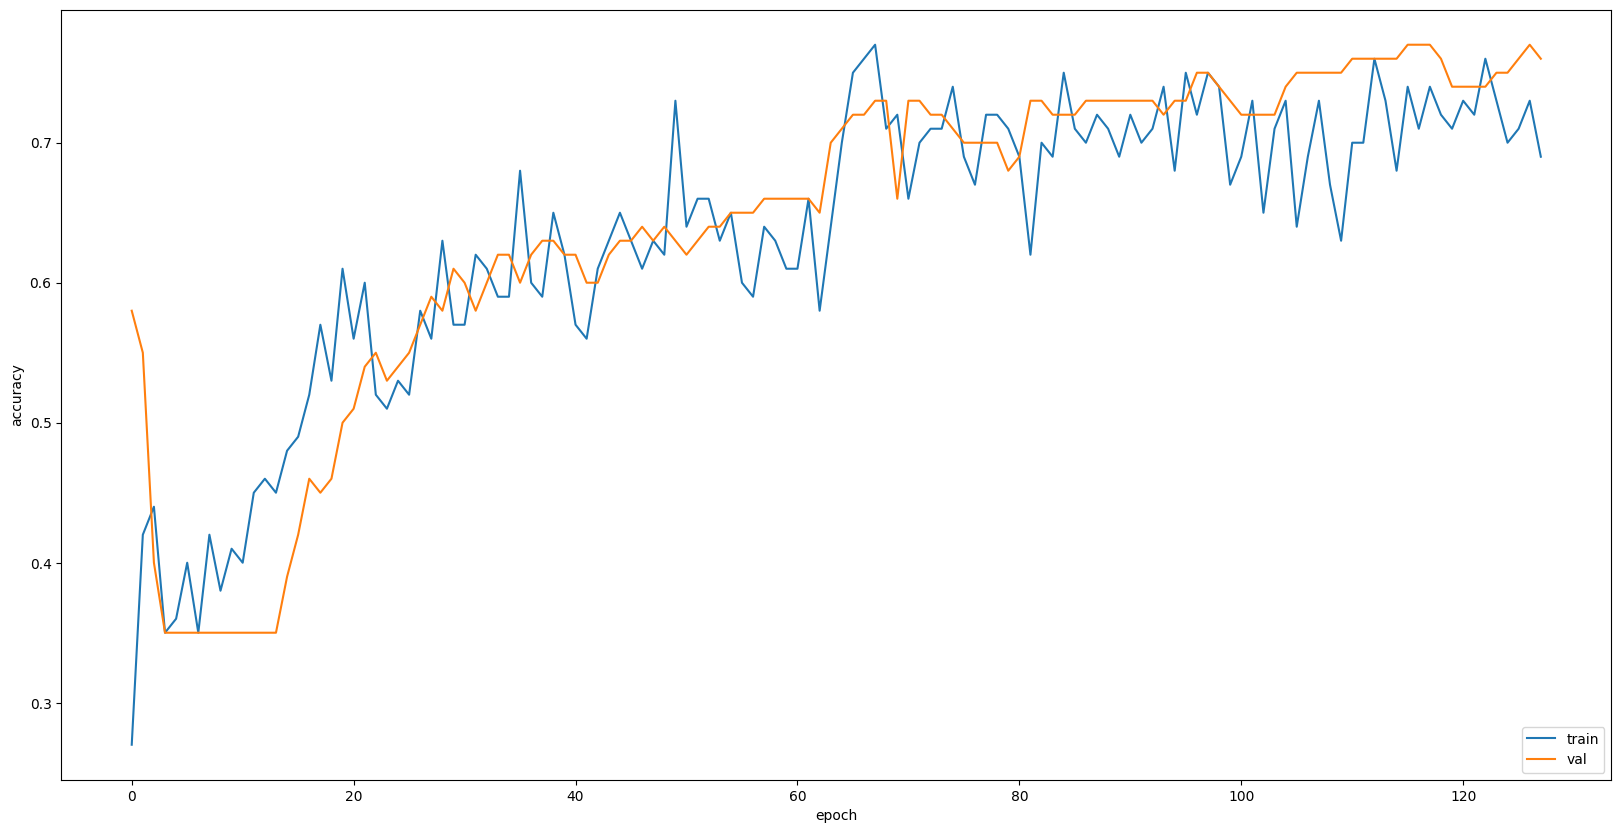

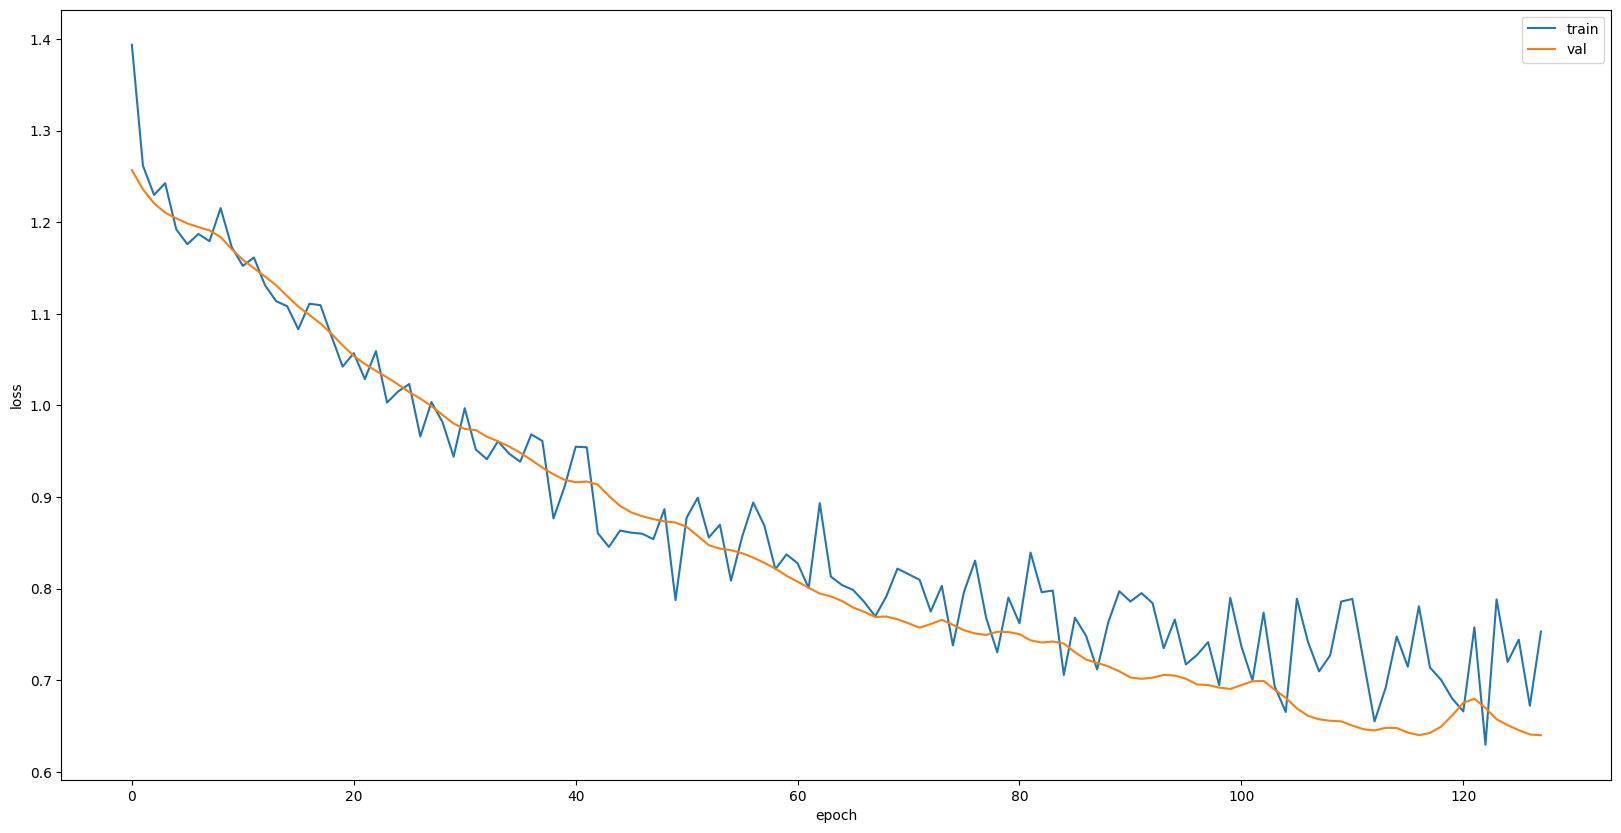

In [26]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

history = model.fit(X_train, Y_train, batch_size=32, validation_data=(X_val, Y_val), epochs=128, verbose=0)

plt.rcParams["figure.figsize"] = (20,10)

# accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

# loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

## **Results**

Show results for each data subset separately.

In [27]:
scores = model.evaluate(X_train, Y_train, verbose=0)
print('TRAINING SET\nLoss:', scores[0], '\nAccuracy:', scores[1])

scores = model.evaluate(X_val, Y_val, verbose=0)
print('\nVALIDATION SET\nLoss:', scores[0], '\nAccuracy:', scores[1])

scores = model.evaluate(X_test, Y_test, verbose=0)
print('\nTEST SET\nLoss:', scores[0], '\nAccuracy:', scores[1])

TRAINING SET
Loss: 0.545936644077301 
Accuracy: 0.8399999737739563

VALIDATION SET
Loss: 0.6399670243263245 
Accuracy: 0.7599999904632568

TEST SET
Loss: 0.5743939876556396 
Accuracy: 0.7850000262260437
